multi-armed bandit experiments - recreating textbook figures
UCB vs ε-greedy comparison
running ucb vs epsilon-greedy comparison...


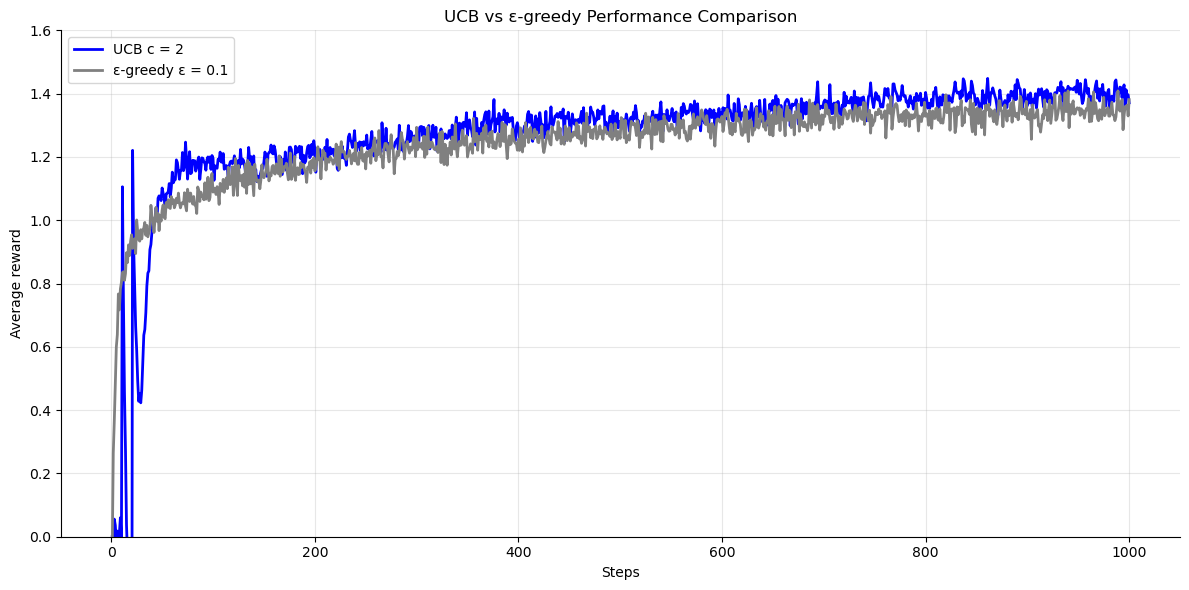

optimistic vs realistic initial values comparison
running optimistic vs realistic comparison...


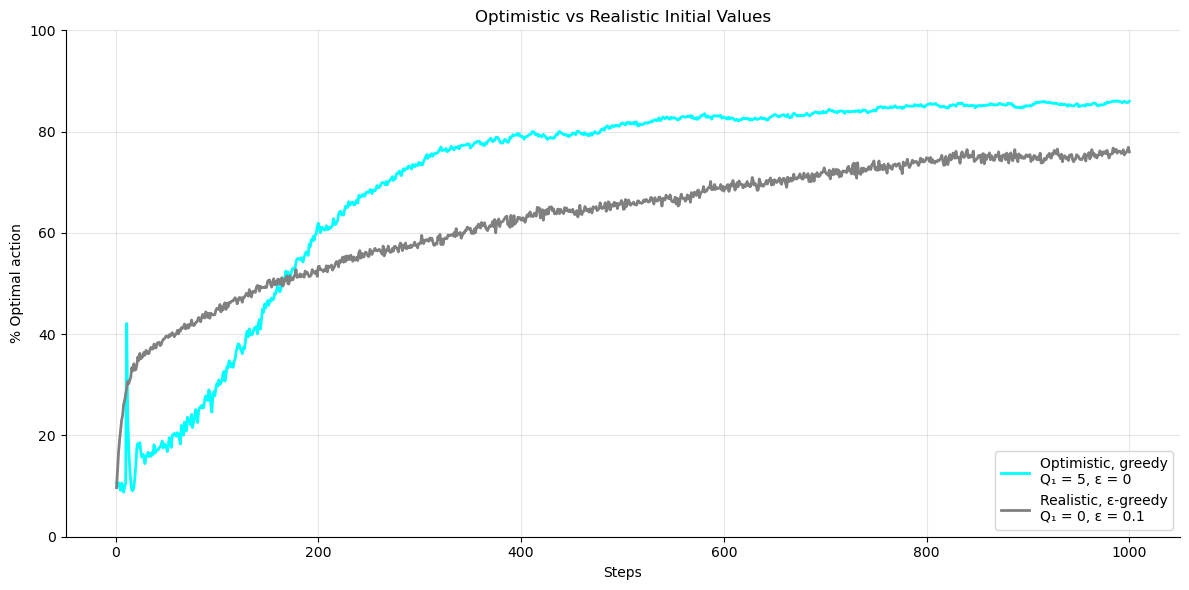

In [ ]:
# Niveen Abdul-Mohsen (bvn9ad)
# Reinforcement Learning (CS 4771) - Multi-armed Bandit Problem
# this code simulates optimistic vs realistic epsilon-greedy and ucb vs epsilon-greedy
# i used numpy for numerical operations and matplotlib for plotting

import numpy as np
import matplotlib.pyplot as plt


def create_bandit_problem(num_arms):
    """
    creates a 10-armed bandit problem like the textbook testbed
    
    from notes: "for the testbed, true values are randomly chosen from normal 
    distribution with mean 0 and variance 1. each arm gets a random true value 
    that represents its expected reward"
    """
    # each arm has a true expected reward drawn from standard normal distribution
    true_values = np.random.normal(0, 1, num_arms)
    # the optimal arm is the one with highest true expected reward
    best_arm = np.argmax(true_values)
    return true_values, best_arm


def get_reward_from_arm(true_value):
    """
    simulates pulling an arm and getting a noisy reward
    
    from notes: "when the agent picks action At, it receives reward Rt picked 
    randomly from normal distribution whose mean is q*(At) and variance 1"
    """
    # reward is normally distributed around the arm's true value
    return np.random.normal(true_value, 1)


def choose_epsilon_greedy_action(q_estimates, epsilon):
    """
    chooses action using epsilon-greedy strategy
    
    from notes: "in ε-greedy methods, at each step: with probability 1−ε, 
    the action with highest estimated value (greedy) is selected. with 
    probability ε, a random action is picked from all possible actions"
    """
    if np.random.random() < epsilon:
        # explore: pick random action to learn more about environment
        return np.random.choice(len(q_estimates))
    else:
        # exploit: pick action with highest estimated reward
        # break ties randomly by finding all max actions and picking one
        max_value = np.max(q_estimates)
        best_actions = np.where(q_estimates == max_value)[0]
        return np.random.choice(best_actions)


def choose_ucb_action(q_estimates, action_counts, timestep, c_param=2):
    """
    chooses action using upper confidence bound strategy
    
    from notes: "ucb picks actions not just by estimated reward Qt(a) but also 
    by uncertainty. if action's value is uncertain (chosen rarely), it gets 
    bonus for uncertainty. formula: At = argmax[Qt(a) + c * sqrt(ln(t) / Nt(a))]"
    """
    # first, try any actions that haven't been selected yet
    untried_actions = np.where(action_counts == 0)[0]
    if len(untried_actions) > 0:
        return np.random.choice(untried_actions)
    
    # calculate ucb values: reward estimate + confidence bonus
    ucb_values = np.zeros(len(q_estimates))
    for arm in range(len(q_estimates)):
        confidence_bonus = c_param * np.sqrt(np.log(timestep) / action_counts[arm])
        ucb_values[arm] = q_estimates[arm] + confidence_bonus
    
    # pick action with highest ucb value (reward + uncertainty bonus)
    return np.argmax(ucb_values)


def update_q_estimate(current_estimate, reward, step_size):
    """
    updates action value estimate using constant step size
    
    from notes: "incremental update formula: Qn+1 = Qn + alpha * (Rn - Qn)
    this is the pattern: NewEstimate = OldEstimate + StepSize * [Target - OldEstimate]"

    """
    return current_estimate + step_size * (reward - current_estimate)


def run_single_bandit_experiment(method, num_arms, num_steps, **settings):
    """
    runs one complete bandit experiment with specified method and settings
    
    from notes: "a learning algorithm tries to learn which actions give best 
    rewards by repeatedly choosing actions over many time steps"
    """
    # create the bandit problem with random true arm values
    true_arm_values, optimal_arm = create_bandit_problem(num_arms)
    
    # initialize q-value estimates and action selection counters
    q_estimates = np.full(num_arms, settings.get('initial_q', 0.0))
    action_counts = np.zeros(num_arms)
    
    # track performance over time
    rewards_received = np.zeros(num_steps)
    optimal_actions_chosen = np.zeros(num_steps, dtype=bool)
    
    # run the experiment step by step
    for step in range(num_steps):
        # choose action based on method
        if method == 'epsilon_greedy':
            action = choose_epsilon_greedy_action(q_estimates, settings['epsilon'])
        elif method == 'ucb':
            action = choose_ucb_action(q_estimates, action_counts, step + 1, settings.get('c', 2))
        
        # pull the chosen arm and observe reward
        reward = get_reward_from_arm(true_arm_values[action])
        rewards_received[step] = reward
        optimal_actions_chosen[step] = (action == optimal_arm)
        
        # update our estimate for the chosen action
        action_counts[action] += 1
        step_size = settings.get('step_size', 0.1)  # use constant step size!
        q_estimates[action] = update_q_estimate(q_estimates[action], reward, step_size)
    
    return rewards_received, optimal_actions_chosen


def run_many_experiments(method, num_runs, num_arms, num_steps, **settings):
    """
    runs multiple experiments and averages results
    
    from notes: "this process (called a run) is repeated for thousands of 
    different random problems to measure how well algorithm learns on average"
    """
    all_rewards = np.zeros((num_runs, num_steps))
    all_optimal_choices = np.zeros((num_runs, num_steps))
    
    for run in range(num_runs):
        rewards, optimal_choices = run_single_bandit_experiment(method, num_arms, num_steps, **settings)
        all_rewards[run] = rewards
        all_optimal_choices[run] = optimal_choices
    
    return all_rewards, all_optimal_choices


def create_ucb_vs_epsilon_plot():
    """
    creates figure comparing ucb vs epsilon-greedy performance
    
    from notes: "ucb generally performs better than ε-greedy, except possibly 
    for the very first k steps where it's still exploring all options"
    """
    # experimental setup
    num_runs = 2000
    num_arms = 10
    num_steps = 1000
    
    print("running ucb vs epsilon-greedy comparison...")
    
    # run ucb experiment
    # from notes: "c controls degree of exploration, larger c = more exploration"
    ucb_rewards, ucb_optimal = run_many_experiments(
        'ucb', num_runs, num_arms, num_steps, c=2, step_size=0.1
    )
    
    # run epsilon-greedy experiment  
    # from notes: "ε=0.1 means 10% random exploration, 90% greedy exploitation"
    eps_rewards, eps_optimal = run_many_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps, epsilon=0.1, step_size=0.1
    )
    
    # calculate average performance across all runs
    ucb_avg_rewards = np.mean(ucb_rewards, axis=0)
    eps_avg_rewards = np.mean(eps_rewards, axis=0)
    
    # create the comparison plot
    plt.figure(figsize=(12, 6))
    steps = np.arange(1, num_steps + 1)
    
    plt.plot(steps, ucb_avg_rewards, 'b-', label='UCB c = 2', linewidth=2)
    plt.plot(steps, eps_avg_rewards, color='gray', label='ε-greedy ε = 0.1', linewidth=2)
    
    plt.xlabel('Steps')
    plt.ylabel('Average reward')
    plt.legend()
    plt.title('UCB vs ε-greedy Performance Comparison')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.6)
    
    # plot styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


def create_optimistic_vs_realistic_plot():
    """
    creates figure comparing optimistic vs realistic initial values
    
    from notes: "optimistic initial values encourage exploration. setting Q1(a) = +5 
    makes agent optimistic about untried actions. as actions are chosen and rewards 
    are usually lower than optimistic estimates, agent gets 'disappointed' and tries others"
    """
    # experimental parameters
    num_runs = 2000
    num_arms = 10
    num_steps = 1000
    
    print("running optimistic vs realistic comparison...")
    # optimistic greedy method
    # from notes: "Q1(a) = +5 if rewards are around 0, makes all actions seem attractive initially"
    # uses pure greedy selection (epsilon = 0) but explores due to optimistic disappointment
    opt_rewards, opt_optimal = run_many_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps,
        epsilon=0.0,      # pure greedy, no forced exploration
        initial_q=5.0,    # optimistic initial estimates
        step_size=0.1     # constant step size
    )
    
    # realistic epsilon-greedy method
    # from notes: "Q1(a) = 0, ε = 0.1 means forced random exploration occasionally"
    real_rewards, real_optimal = run_many_experiments(
        'epsilon_greedy', num_runs, num_arms, num_steps,
        epsilon=0.1,      # 10% random exploration
        initial_q=0.0,    # realistic initial estimates  
        step_size=0.1     # constant step size
    )
    
    # calculate percentage of optimal actions chosen over time
    opt_percent_optimal = np.mean(opt_optimal, axis=0) * 100
    real_percent_optimal = np.mean(real_optimal, axis=0) * 100
    
    # create the comparison plot
    plt.figure(figsize=(12, 6))
    steps = np.arange(1, num_steps + 1)
    
    # plot both curves
    plt.plot(steps, opt_percent_optimal, color='cyan', linewidth=2,
             label='Optimistic, greedy\nQ₁ = 5, ε = 0')
    plt.plot(steps, real_percent_optimal, color='gray', linewidth=2,
             label='Realistic, ε-greedy\nQ₁ = 0, ε = 0.1')
    
    plt.xlabel('Steps')
    plt.ylabel('% Optimal action')
    plt.title('Optimistic vs Realistic Initial Values')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 100)
    
    # plot styling
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()



def main():
    print("multi-armed bandit experiments - recreating textbook figures")
    print("=" * 60)
    
    # set random seed
    np.random.seed(42)
    
    print("UCB vs ε-greedy comparison")
    create_ucb_vs_epsilon_plot()
    
    print("optimistic vs realistic initial values comparison")
    create_optimistic_vs_realistic_plot()

if __name__ == "__main__":
    main()
